## Lab 7: Eel Distribution Modeling with XGBoost

**Reference Paper:** [Elith et al. (2008)](https://ucsb.box.com/s/6k7636wsbogdg3orarxrlowke0ounbic)

In this lab, you will model the distribution of the eel species *Anguilla australis* using **boosted classification trees (BCTs)**, a machine learning technique that improves predictive performance by combining multiple decision trees. Elith et al. (2008) offered an early implementation of BRTs in an ecological setting to understand how environmental variables influence eel distribution.

You will work with **two datasets**:
1. **Training Data** – Used to build and evaluate your XGBoost model.
2. **Evaluation Data** – Used to assess model performance on unseen data.

To achieve the following objectives:
- Train and fine-tune an **XGBoost** model for classification of species presence/absence data.
- Compare your model’s performance to the approach used by Elith et al.


**Wherever applicable in this lab, use a random state of 808.**

### Step 0: Load libraries and data


In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split,RandomizedSearchCV
from sklearn.datasets import make_moons
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
from scipy.stats import uniform, randint

from sklearn.metrics import log_loss
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.metrics import accuracy_score, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns


# Download the datasets
model_data = pd.read_csv("/courses/EDS232/Data/model.data.csv").drop(columns=['Site'])
eval_data = pd.read_csv("/courses/EDS232/Data/eval.data.csv")

### Step 1:Initial Data Preprocessing
Let's get started by preparing our data. `Angaus` will be our target variable(`y`), and all other variables will be our features (`X`). Then encode the categorical feature using `LabelEncoder()`. The final step will be a bit different this time.  We don't need to split off testing data for the final model evaluation; a separate set (`eval_data`) will be used as in Elith et al.  We do, however, need to split our data in order to do the early stopping process. When splitting your data into training and validation, use a test size of 0.2 and a random state of 808. 

Notes:

Learning rate is: # how much are we going to change the parameter value. at a given step along optimization, we use gradient that gives biggest decrease in loss function (thing we are trying to minimize)

Uniform is a square distribution, it is saying start at the first, the second value is the length of the range. Values from 0.01 - 0.3. (0.3 is the length of the range) 

In [2]:
# ---- Define X & y variables ----

y = model_data['Angaus']
X = model_data.drop('Angaus', axis = 1)

In [3]:
# ---- Encode X data ----

# Initialize the encoder
le = LabelEncoder()

# Encode the "Method" column
X["Method"] = le.fit_transform(X["Method"])

# ---- Split X into test and train for early stopping ----

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 808)

### Step 2: Determine best number of trees using early stopping
As a guard against overfitting while maximizing performance, we use **early stopping**. We start with a large number of trees and allow XGBoost to determine the optimal number by stopping training when the validation error no longer improves.

The choice of hyperparameter starting values is important in this process. We begin with:
- `n_estimators=1000` to ensure the model has enough capacity to learn meaningful patterns.
- `learning_rate=0.1` as a reasonable default that balances learning speed and performance.
- `eval_metric="logloss"` as the metric of performance to optimize.
- `early_stopping_rounds=50` to halt training if no improvement is seen for 50 rounds, preventing unnecessary computations.
- `random_state = 808`

We then `fit()` our specified baseline model, passing in the training sets as usual and specifying validation sets values for the `eval_set` parameter.

Finally, get and print the best number of trees from the fitted baseline model.


In [4]:
# ---- Define and fit baseline model ----

# Define XGBoost model
model = xgb.XGBClassifier(n_estimators = 1000,
                          early_stopping_rounds = 50,
                          learning_rate = 0.1,
                          eval_metric = "logloss",
                          random_state = 808,
                          n_jobs = -1) # optimize comp power
 
# Fit the model
model.fit(X_train,
          y_train,
         eval_set=[(X_test, y_test)],
         verbose = 0)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=50, enable_categorical=False,
              eval_metric='logloss', gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_bin=256,
              max_cat_to_onehot=4, max_delta_step=0, max_depth=6, max_leaves=0,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=-1, num_parallel_tree=1,
              predictor='auto', random_state=808, reg_alpha=0, reg_lambda=1, ...)

In [5]:
print(f"Best number of trees for the baseline model: {model.best_iteration}")
best_trees = model.best_iteration

Best number of trees for the baseline model: 34


### Step 3: Tune Learning Rate

The (`learning_rate` hyperparameter controls how much each tree contributes to improving the model's performance. A *higher* learning rate allows the model to learn quickly but risks missing the optimal solution and overfitting, while a *lower* learning rate makes learning slower but can improve generalization.

To find the optimal value, we'll use **randomized search cross-validation** (`RandomizedSearchCV`) to test different learning rates in the 0.01 to 0.3 range. Instead of testing every possible value, this method samples a set number of candidates (`n_iter`) from a defined parameter distribution.  In this case, sampling 20 candidates from a uniform distribution between `0.01` and `0.31`. Check out the [documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.uniform.html) on `scipy.stats.uniform` to see how it differs from `random.uniform`. Be sure to use a random state of 808.

After using `RandomizedSearchCV`, fit your model. Print the best learning rate. 


In [6]:
# Define hyperparameter distributions
param_dist = {
    "learning_rate": uniform(0.01, 0.3),
}


# Define XGBoost model
model_bt = xgb.XGBClassifier(n_estimators = best_trees,
                             # eval_metric = "logloss",
                          random_state = 808)

# Set up RandomizedSearchCV (ranges for hyperparameters, randomly selects values in tuning)
random_search = RandomizedSearchCV(
    model_bt,
    param_dist,
    cv = 5, # Annie told me this
    n_iter = 20,
    random_state = 808,
    n_jobs = -1)

# Fit the model
random_search.fit(X_train, y_train) 

RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, gamma=None,
                                           gpu_id=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None, max_bin=None,...
                                           max_delta_step=None, max_depth=None,
                                           max_leaves=None

In [7]:
print(f"Best learning rate: {random_search.best_params_['learning_rate']}")

best_learning_rate = random_search.best_params_['learning_rate']

Best learning rate: 0.19644487306375513


### Step 4: Tune Tree-Specific Parameters

Now that we've determined the best number of tree and learning rate, we need to tune the complexity of individual trees in our model. Initialize your model with the best number of trees and learning rate.Then, define a parameter dictionary that takes on the following values:  

- `max_depth`(Controls how deep each tree can grow.  Takes integer values): A random integer from 3 to 10 ( inclusive of 3 and 10)
- `min_child_weight`( Determines the minimum number of samples required in a leaf node. Takes integer values) : A random integer from 1 to 10 ( inclusive of 1 and 10)
- `gamma` (Defines the minimum loss reduction needed to make a further split in a tree. Can take on values from a continuous range):  A uniform distribution from 0.05 to 0.10 - once again remember to check the `scipy.stats.uniform()` documentation! 
- `random_state = 808`

To find the best combination, we again use `RandomizedSearchCV`, allowing us to efficiently sample hyperparameters and evaluate different configurations using cross-validation. After fitting the model, print the best parameters. 

In [23]:
# ---- Tune tree specific paraemters  ----

# Define XGBoost model
model_blr = xgb.XGBClassifier(
    n_estimators = best_trees,
    learning_rate  = best_learning_rate,
    random_state = 808,
    verbose=0,
    n_jobs = -1)

# Define parameter dictionary
param_dist = {
    'max_depth': randint(3, 11),
    'min_child_weight': randint(1, 11),
    'gamma': uniform(0.05, 0.05),
}

# Find best combination of parameteres
random_search = RandomizedSearchCV(
    model_blr,
    param_dist,
    n_iter = 20, # should I keep this
    random_state = 808,
    cv = 5,
    n_jobs = -1
)


# Fit the model to find the best parameters
random_search.fit(X_train, y_train)


[00:12:14] WARNING: ../src/learner.cc:627: 
Parameters: { "verbose" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, gamma=None,
                                           gpu_id=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=0.1964448730637551...
                                           predictor=None, random_state=808,
                                           reg_alpha=None, reg

In [24]:
print("Best stochastic params:", random_search.best_params_)

best_params = random_search.best_params_
#best_gamma = random_search.best_params_['gamma']
#best_max_depth = random_search.best_params_['max_depth']
#best_min_child_weight = random_search.best_params_['min_child_weight']

Best stochastic params: {'gamma': 0.08506612141420486, 'max_depth': 8, 'min_child_weight': 7}


### Step 5: Tune Stochastic Components

Now, we are finally ready to tune the stochastic components of the XGBoost model.  These parameters help prevent overfitting by reducing correlation between trees. Initialize your model with the best number of trees, best learning rate,and your optimized tree values (**Note**: you can use \**best_tree_parameters to unpack the the dictionary of optimzed tree values) .Then, define a parameter dictionary that takes on the following values:  

- `subsample` (Controls the fraction of training samples used for each boosting round) : A uniform distribution between .5 and 1 (remeber to check `scipy.stats.uniform()` documentation! )
- `colsample_bytree`(Specifies the fraction of features to consider when building each tree) : A uniform distribution between .5 and 1
- `random_state = 808`

We again use `RandomizedSearchCV` to find the best combination of these parameters. After fitting the model, print the best parameters. 


In [26]:
# Define XGBoost model
model_stochastic = xgb.XGBClassifier(
    n_estimators = best_trees,
    learning_rate  = best_learning_rate,
    **best_params,
    #gamma = best_gamma,
    #max_depth = best_max_depth,
    #min_child_weight = best_min_child_weight, 
   eval_metric = "logloss", # do I keep this
    random_state = 808,
    n_jobs = -1)

# Define dictionary
param_dist = {
    'subsample': uniform(0.5, 0.5),
    'colsample_bytree': uniform(0.5, 0.5)
}

# Find best combination of parameters
random_search = RandomizedSearchCV(
    model_stochastic,
    param_dist,
    n_iter = 20,
    random_state = 808,
    n_jobs = -1)

random_search.fit(X_train, y_train)

random_search.best_params_

{'colsample_bytree': 0.7892287535709286, 'subsample': 0.5751566263521946}

In [11]:
print("Best stochastic params:", random_search.best_params_)

best_stochastic_params = random_search.best_params_
#best_colsample_bytree = random_search.best_params_['colsample_bytree']
#best_subsample = random_search.best_params_['subsample']

Best stochastic params: {'colsample_bytree': 0.7892287535709286, 'subsample': 0.5751566263521946}


### Step 6: Final Model Training and Evaluation

With the best hyperparameters selected, we now train the final model on the full training dataset and evaluate it on the separate evaluation dataset.

1. Prepare the evaluation data in the same manner as you did the training data

2. Train final model using the best parameters found in previous tuning steps (`best_tree_params`, `best_stochastic_params`).Set  `eval_metric = "logloss"` 

3. Fit the model to the full training dataset and predict on the evaluation data 


In [12]:
# ---- Define X & y variables ----

y_test = eval_data['Angaus_obs']
X_test = eval_data.drop('Angaus_obs', axis = 1)

In [27]:
# ---- Encode X data ----

# Initialize the encoder
le = LabelEncoder()

# Encode the "Method" column
X_test["Method"] = le.fit_transform(X_test["Method"])


# ---- Define the model ----

# Define XGBoost model
final_model = xgb.XGBClassifier(n_estimators = best_trees,
                          learning_rate = best_learning_rate,
                          **best_stochastic_params,
                          **best_params,
                          eval_metric = "logloss",
                          random_state = 808, 
                          n_jobs = -1)

# Fit the model
final_model.fit(X, y)

# ---- Predict on evaluation data ----

y_pred = final_model.predict(X_test)

### Step 7: Model Performance

Compute and print the AUC and feature importances for your model.

In [28]:
# ---- Calculate and plot ROC curve ----

# Calculate probability
final_model_probs = final_model.predict_proba(X_test)[:, 1]

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, final_model_probs)

auc = roc_auc_score(y_test, final_model_probs)


# ---- Extract feature importance ----
feature_importance = final_model.feature_importances_
feature_names = X_train.columns

# put it back into df
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
importance_df = importance_df.sort_values('Importance', ascending = False)



In [29]:
print(auc)
print(importance_df)

0.8711207819076834
       Feature  Importance
0      SegSumT    0.178589
10      Method    0.138008
8     USNative    0.118784
4   DSMaxSlope    0.109995
7      USSlope    0.090712
11      LocSed    0.065923
6   USRainDays    0.064563
5       USAvgT    0.063996
2   SegLowFlow    0.058490
1     SegTSeas    0.055981
3       DSDist    0.054959
9        DSDam    0.000000


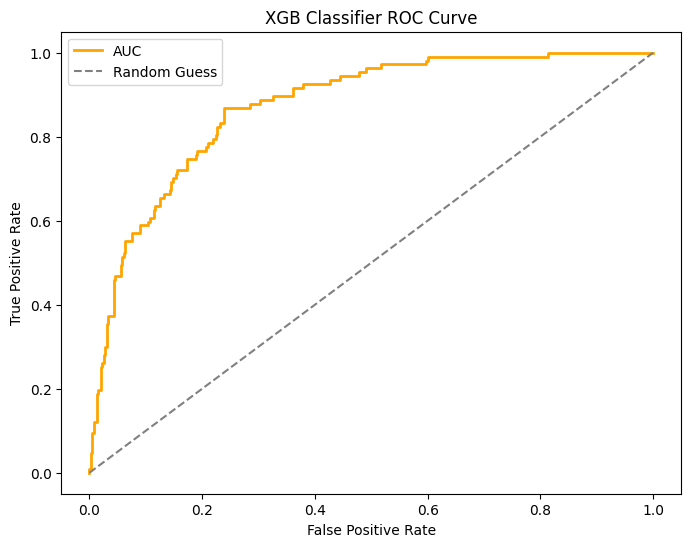

In [16]:
# ---- Plot ROC curve ----

# Plot histograms for both classes
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label="AUC", color="orange", lw=2)
plt.plot([0, 1], [0, 1], color="gray", linestyle="--", label="Random Guess")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("XGB Classifier ROC Curve")
plt.legend()
plt.legend()
plt.show()

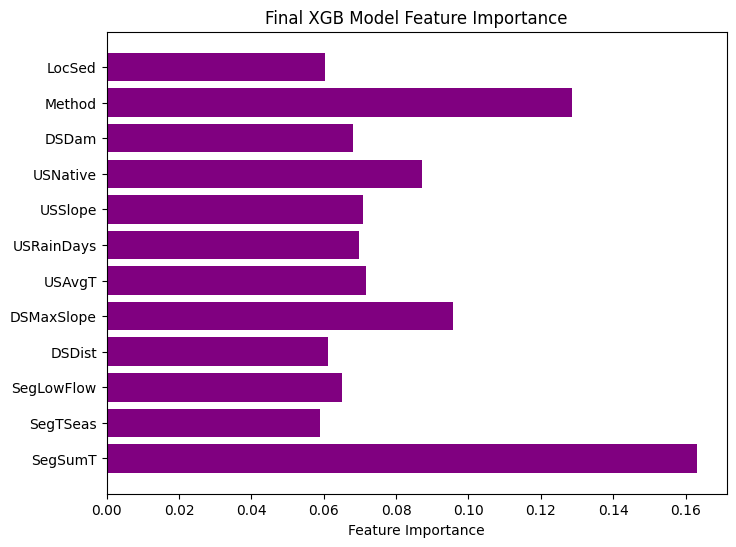

In [18]:
# ---- Plot feature importance ----

# Visualize feature importance with bar plot
plt.figure(figsize=(8, 6))
plt.barh(feature_names, feature_importance,  color = "purple")
plt.yticks(feature_names)
plt.xlabel('Feature Importance')
plt.title('Final XGB Model Feature Importance')
plt.show()

### Step 8: The comparison
How does your model's performance compare to the of Elith et al. (See Tables 2 and 3)?  Is there another way to compare the models in addition to predictive performance?  Whose model wins in that regard?


Another way to compare the model in addition to predictive performance is in the models simplicity to develop, interpretability, and computational power. The XGB Model was more accurate in terms of predictive power, but the model is much more difficult to develop and interpret and its computational load is likely signficiantly higher.

